In [12]:
# Imports
import pandas as pd
import numpy as np
from math import sqrt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Load CSVs
base_path = "."
temperature = pd.read_csv("2/temperature.csv")
humidity = pd.read_csv("2/humidity.csv")
pressure = pd.read_csv("2//pressure.csv")
wind_speed = pd.read_csv("2//wind_speed.csv")
wind_direction = pd.read_csv("2//wind_direction.csv")
weather_description = pd.read_csv("2//weather_description.csv")
city_attributes = pd.read_csv("2//city_attributes.csv")

In [3]:
# Wide to Long
def wide_to_long(df, value_name):
    return df.melt(id_vars="datetime", var_name="city", value_name=value_name)

temp_long = wide_to_long(temperature, "temperature")
hum_long = wide_to_long(humidity, "humidity")
pres_long = wide_to_long(pressure, "pressure")
wspd_long = wide_to_long(wind_speed, "wind_speed")
wdir_long = wide_to_long(wind_direction, "wind_direction")
wdesc_long = wide_to_long(weather_description, "weather_description")

df = (
    temp_long
    .merge(hum_long, on=["datetime","city"])
    .merge(pres_long, on=["datetime","city"])
    .merge(wspd_long, on=["datetime","city"])
    .merge(wdir_long, on=["datetime","city"])
    .merge(wdesc_long, on=["datetime","city"])
)

city_attr = city_attributes.rename(columns={"City":"city"})
df = df.merge(city_attr, on="city", how="left")

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values(["city","datetime"]).dropna().reset_index(drop=True)
print(df.shape)

(1596319, 11)


In [4]:
# Encode
le = LabelEncoder()
df["weather_code"] = le.fit_transform(df["weather_description"].astype(str))
df["temp_target"] = df["temperature"]

In [5]:
# Split
split_time = df["datetime"].quantile(0.8)
train_df = df[df["datetime"] < split_time].copy()
test_df = df[df["datetime"] >= split_time].copy()

print(train_df.shape, test_df.shape)

(1277030, 13) (319289, 13)


In [6]:
# Scale
feature_cols_num = [
    "temperature","humidity","pressure",
    "wind_speed","wind_direction",
    "Latitude","Longitude","weather_code"
]

scaler = MinMaxScaler()
train_df[feature_cols_num] = scaler.fit_transform(train_df[feature_cols_num])
test_df[feature_cols_num] = scaler.transform(test_df[feature_cols_num])

In [7]:
# Sequences
look_back = 24

def make_sequences(df_, look_back, feature_cols, target_col):
    X, y = [], []
    for city, group in df_.groupby("city"):
        group = group.sort_values("datetime")
        feat = group[feature_cols].values
        tgt = group[target_col].values
        if len(group) <= look_back:
            continue
        for i in range(look_back, len(group)):
            X.append(feat[i-look_back:i])
            y.append(tgt[i])
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_df, look_back, feature_cols_num, "temp_target")
X_test, y_test = make_sequences(test_df, look_back, feature_cols_num, "temp_target")

print(X_train.shape, X_test.shape)

(1276166, 24, 8) (318425, 24, 8)


In [8]:
# Model builder
def build_lstm_model(units=64, dropout=0.2, lr=1e-3, input_shape=None):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

input_shape = (look_back, len(feature_cols_num))

In [10]:

param_grid = [
    {"units":32,"dropout":0.2,"lr":1e-3,"batch_size":64},
    {"units":64,"dropout":0.2,"lr":1e-3,"batch_size":64},
    {"units":64,"dropout":0.3,"lr":5e-4,"batch_size":128},
    {"units":128,"dropout":0.2,"lr":1e-3,"batch_size":128}
]

best_val_loss = np.inf
best_params = None
best_model = None

# Wrap the param_grid iteration with tqdm for a progress bar
for p in tqdm(param_grid, desc="Hyperparameter Tuning"):
    model = build_lstm_model(p["units"], p["dropout"], p["lr"], input_shape)
    es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=p["batch_size"],
        validation_split=0.2,
        callbacks=[es],
        verbose=1
    )
    val_loss = min(history.history["val_loss"])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = p
        best_model = model

print("Best Parameters:", best_params)
print("Best Validation Loss:", best_val_loss)

Hyperparameter Tuning:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 16446.0977 - val_loss: 23.8497
Epoch 2/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 603.9517 - val_loss: 5.0141
Epoch 3/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 557.7299 - val_loss: 2.2430
Epoch 4/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 522.7162 - val_loss: 5.9487
Epoch 5/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - loss: 487.9612 - val_loss: 10.1847


Hyperparameter Tuning:  25%|██▌       | 1/4 [04:30<13:30, 270.01s/it]

Epoch 1/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - loss: 8405.8916 - val_loss: 9.3349
Epoch 2/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 314.4051 - val_loss: 3.9121
Epoch 3/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 297.1097 - val_loss: 9.1102
Epoch 4/10
15953/15953 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 282.8092 - val_loss: 5.1813


Hyperparameter Tuning:  50%|█████     | 2/4 [08:07<07:58, 239.28s/it]

Epoch 1/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 30164.9551 - val_loss: 3296.3640
Epoch 2/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 997.5873 - val_loss: 13.3796
Epoch 3/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 550.4425 - val_loss: 5.7690
Epoch 4/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 535.6995 - val_loss: 4.5094
Epoch 5/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 523.0326 - val_loss: 3.4400
Epoch 6/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 512.4648 - val_loss: 8.4375
Epoch 7/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 504.2747 - val_loss: 25.2197


Hyperparameter Tuning:  75%|███████▌  | 3/4 [11:19<03:37, 217.34s/it]

Epoch 1/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 8381.2119 - val_loss: 74.8798
Epoch 2/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 212.5916 - val_loss: 7.7219
Epoch 3/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 168.6533 - val_loss: 2.8072
Epoch 4/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 161.0321 - val_loss: 18.3102
Epoch 5/10
7977/7977 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 156.9429 - val_loss: 3.0703


Hyperparameter Tuning: 100%|██████████| 4/4 [13:34<00:00, 203.55s/it]

Best Parameters: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 64}
Best Validation Loss: 2.242969512939453


In [11]:
# Evaluate
y_pred = best_model.predict(X_test).ravel()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

9951/9951 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
RMSE: 1.5686083651725078
R2: 0.9758479238803685


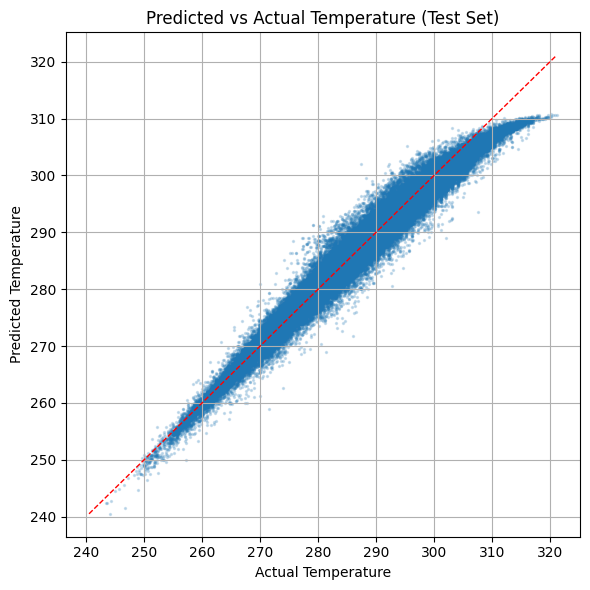

In [13]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2, s=2)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Predicted vs Actual Temperature (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


Plotting for city: Albuquerque
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


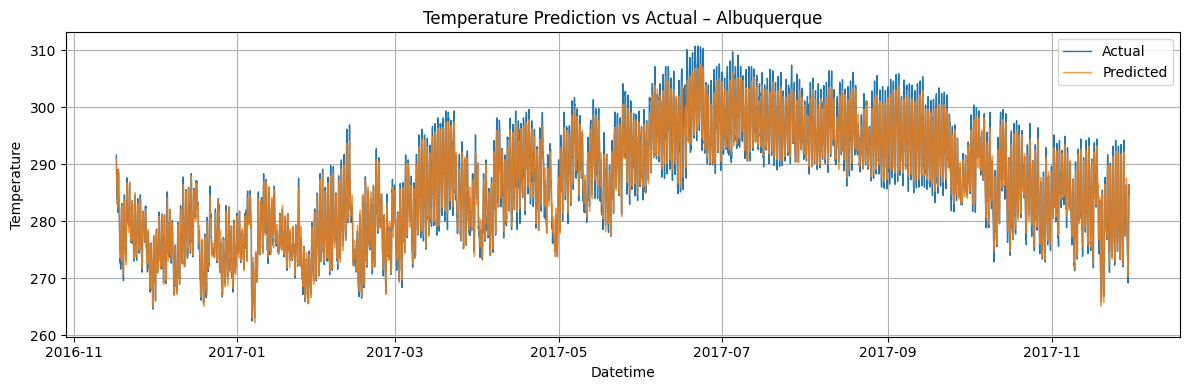

In [14]:
# Pick a city from the test set (you can change this)
city_name = test_df['city'].unique()[0]
print("Plotting for city:", city_name)

city_group = (
    test_df[test_df['city'] == city_name]
    .sort_values('datetime')
    .reset_index(drop=True)
)

# Rebuild sequences for this city
X_city, y_city = make_sequences(city_group, look_back, feature_cols_num, "temp_target")
y_city_pred = best_model.predict(X_city).ravel()

# Datetime aligned with targets (last time step of each window)
dt_city = city_group["datetime"].values[look_back:]

plt.figure(figsize=(12, 4))
plt.plot(dt_city, y_city, label="Actual", linewidth=1)
plt.plot(dt_city, y_city_pred, label="Predicted", linewidth=1, alpha=0.8)

plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.title(f"Temperature Prediction vs Actual – {city_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


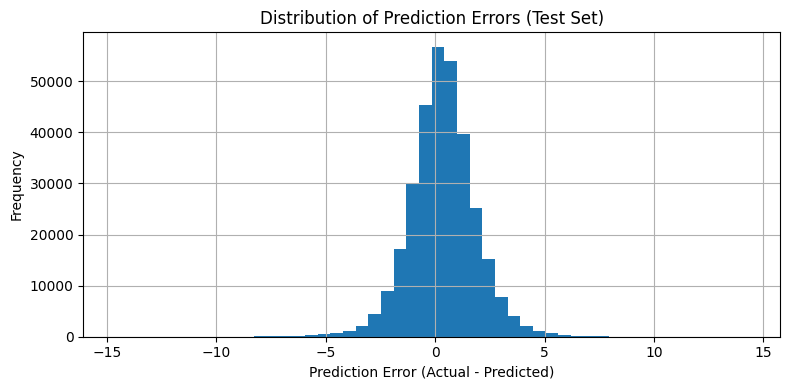

Mean error  : 0.33777193825607527
Std of error: 1.5318101452255437


In [15]:
errors = y_test - y_pred  # Actual - Predicted

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50)
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Mean error  :", errors.mean())
print("Std of error:", errors.std())


In [16]:
city_metrics = []

for city, group in test_df.groupby("city"):
    group = group.sort_values("datetime").reset_index(drop=True)
    
    if len(group) <= look_back:
        continue  # not enough data to form a sequence

    X_c, y_c = make_sequences(group, look_back, feature_cols_num, "temp_target")
    y_c_pred = best_model.predict(X_c).ravel()

    rmse_c = np.sqrt(mean_squared_error(y_c, y_c_pred))
    r2_c = r2_score(y_c, y_c_pred)

    city_metrics.append({
        "city": city,
        "rmse": rmse_c,
        "r2": r2_c
    })

city_metrics_df = pd.DataFrame(city_metrics).sort_values("rmse")
print("Top 10 best cities (lowest RMSE):")
print(city_metrics_df.head(10))

print("\nTop 10 worst cities (highest RMSE):")
print(city_metrics_df.tail(10))


283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━

In [17]:
def make_sequences_with_weather(df_, look_back, feature_cols, target_col):
    X, y, weather = [], [], []
    for city, group in df_.groupby("city"):
        group = group.sort_values("datetime").reset_index(drop=True)
        features = group[feature_cols].values
        target = group[target_col].values
        wdesc = group["weather_description"].values

        if len(group) <= look_back:
            continue

        for i in range(look_back, len(group)):
            X.append(features[i - look_back : i])
            y.append(target[i])
            weather.append(wdesc[i])  # weather at prediction time

    return np.array(X), np.array(y), np.array(weather, dtype=object)

X_w, y_w, weather_labels = make_sequences_with_weather(
    test_df, look_back, feature_cols_num, "temp_target"
)
y_w_pred = best_model.predict(X_w).ravel()

weather_metrics = []
for w in np.unique(weather_labels):
    mask = (weather_labels == w)
    if mask.sum() < 500:  # skip very rare conditions if you want
        continue
    rmse_w = np.sqrt(mean_squared_error(y_w[mask], y_w_pred[mask]))
    r2_w = r2_score(y_w[mask], y_w_pred[mask])
    weather_metrics.append({
        "weather_description": w,
        "rmse": rmse_w,
        "r2": r2_w,
        "count": mask.sum()
    })

weather_metrics_df = pd.DataFrame(weather_metrics).sort_values("rmse")
print(weather_metrics_df)


9951/9951 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
            weather_description      rmse        r2   count
3                           fog  1.074540  0.979331    6280
10                         mist  1.155463  0.979670   34182
6       light intensity drizzle  1.184135  0.974582    3577
1                       drizzle  1.210004  0.969247    1184
12              overcast clouds  1.224849  0.981175   27836
7   light intensity shower rain  1.231653  0.957868    1150
9                    light snow  1.238454  0.939074    3928
8                    light rain  1.298439  0.971800   17593
13        proximity shower rain  1.412543  0.982831     943
11                moderate rain  1.428244  0.958860    2779
0                 broken clouds  1.488095  0.975450   31447
5          heavy intensity rain  1.503820  0.956077     649
4                          haze  1.553859  0.970558    9814
15             scattered clouds  1.596866  0.971688   26994
18                 thunderstorm  1.627103  0.933634     

In [19]:
best_model.save("best_lstm_model.keras")
print("Saved as best_lstm_model.keras")


Saved as best_lstm_model.keras
